In [1]:
import keras
import numpy as np
import cv2
import os
import sys
import glob
import shutil
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
from model import *
from data import *

In [3]:
AREA_THRESHOLD = 1500
IS_COLOR_MASK = True

In [4]:
path_to_target_images = './data/sky/iphone500/test'

In [5]:
path_to_rawmasks = './data/sky/raw_data'
path_to_masks = './data/sky/test'
path_to_results = './data/sky/result'

In [6]:
shutil.rmtree(path_to_masks, ignore_errors=True)

if not os.path.exists(path_to_masks):
    os.mkdir(path_to_masks)

In [7]:
shutil.rmtree(path_to_rawmasks, ignore_errors=True)

if not os.path.exists(path_to_rawmasks):
    os.mkdir(path_to_rawmasks)

In [8]:
shutil.rmtree(path_to_results, ignore_errors=True)

if not os.path.exists(path_to_results):
    os.mkdir(path_to_results)

In [9]:
images = glob.glob(os.path.join(path_to_target_images, '*'))
images.sort()

In [10]:
model = unet()
model.load_weights('models/Unet.17-0.98.hdf5')

/home/dmitrii/sky_detect/Semantic-Segmentation-Suite/UNET/sky-segmentation/keras_unet/model.py:58: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv10)


## Mask prediction by model 

In [11]:
dataGen = testGenerator(path_to_target_images)

In [12]:
raw_masks = model.predict_generator(dataGen, len(images), verbose=1)
saveResult(path_to_rawmasks, raw_masks)

10/10 [==============================] - 2s 232ms/step


/home/dmitrii/.virtenvs/FaceIidentification/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


## Post processing via opencv algorithm

In [13]:
raw_masks = glob.glob("data/sky/raw_data/*")
raw_masks.sort()
results = []
for path in raw_masks:
    
    raw_mask = cv2.imread(path)
    
    # Otsu threshold
    blur = cv2.GaussianBlur(raw_mask[:,:,0],(5,5),0)
    ret,thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Contour detection
    _, contours, hierarchy = cv2.findContours( thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contour by area
    contour_list = []
    area_threshold = AREA_THRESHOLD

    for contour in contours:
        area = cv2.contourArea(contour)
        if area > area_threshold :
            contour_list.append(contour)
            
    # Making binary mask by contour        
    countMask = np.zeros(thresh.shape, dtype='uint8')
    cv2.drawContours(countMask, contour_list, -1, (255, 255, 255), cv2.FILLED)
    
    # Restore accuracy of board between sky and other objects
    mask = np.add(cv2.bitwise_not(thresh), cv2.bitwise_not(countMask))
    
    mask = cv2.bitwise_not(mask)    
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
#     cv2.imwrite('{}.png'.format(9), mask)
#     mask = np.expand_dims(mask, 2)
        
    results.append(mask)

In [14]:
saveResult(path_to_masks, np.array(results))

## Adding mask to original image

In [15]:
labels = glob.glob(os.path.join(path_to_masks, '*'))
labels.sort()

In [16]:
def addMask(back_path, over_path, new_path):
    background = io.imread(back_path)
    background = cv2.resize(background, (1024, 1024))
    overlay = io.imread(over_path)
    overlay = cv2.resize(overlay, (1024, 1024))

    mask = cv2.bitwise_not(overlay)    
    img_mask = background.copy()
    img_mask[mask == 0] = [255, 0, 0]
    
    rows,cols,channels = background.shape
    background = cv2.addWeighted(background,0.5,img_mask,0.4,0.5)
        

    io.imsave(new_path,background)

In [17]:
for i in range(len(labels)):
    addMask(images[i], labels[i], os.path.join(path_to_results, "{}.jpg".format(i)))

## Results

In [18]:
images = glob.glob(os.path.join(path_to_target_images, '*'))
images.sort()
result_images = glob.glob(os.path.join(path_to_results, '*'))
result_images.sort()

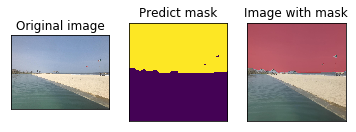

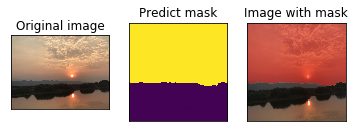

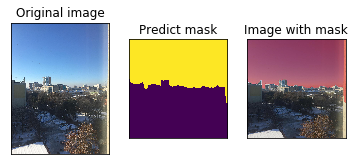

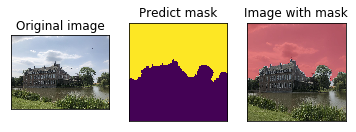

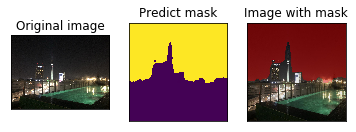

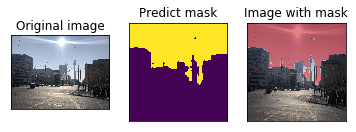

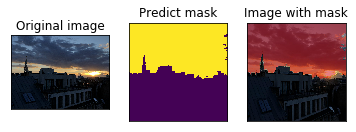

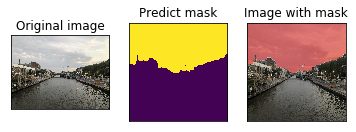

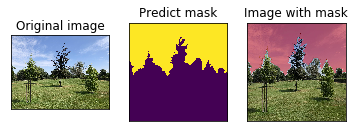

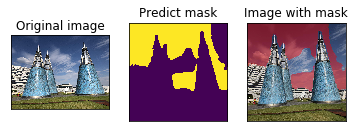

In [19]:
j = 0
for i in range(len(labels)):
    original_image = images[i]
    mask = labels[i]
    image_and_mask = result_images[i]
    
    im = io.imread(original_image)
    ms = io.imread(mask)
    im_ms = io.imread(image_and_mask)
        
    titles = ['Original image','Predict mask','Image with mask']
    imges = [im, ms, im_ms]

    for i in range(3):
        plt.subplot(1,3,i+1),plt.imshow(imges[i])
        plt.title(titles[i])
        plt.xticks([]),plt.yticks([])
        tmp = cv2.resize(imges[i], (2048, 2048))
        plt.imsave('./data/{}.png'.format(j), tmp)
        j += 1
    plt.show()
    